## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint

#model_ckpt = ModelCheckpoint(filepath="./d65sample.h5", 
#                             monitor="val_loss", 
#                             save_best_only=True)
MODEL_CKPT = [ModelCheckpoint(filepath="./d65HW_TF.h5", monitor="val_loss", save_best_only=True, save_weights_only=False),
              ModelCheckpoint(filepath="./d65HW_FF.h5", monitor="val_loss", save_best_only=False, save_weights_only=False),
              ModelCheckpoint(filepath="./d65HW_TT.h5", monitor="val_loss", save_best_only=True, save_weights_only=True),
              ModelCheckpoint(filepath="./d65HW_FT.h5", monitor="val_loss", save_best_only=False, save_weights_only=True)]

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for model_ckpt in MODEL_CKPT:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with checkPt = %s" % (str(model_ckpt)))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train,
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )
    
     # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-%s" % (str(model_ckpt))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with checkPt = <keras.callbacks.callbacks.ModelCheckpoint object at 0x000001DD1A0C0088>
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__________________________

50000/50000 [==============================] - 7s 130us/step - loss: 0.6962 - accuracy: 0.7796 - val_loss: 1.5597 - val_accuracy: 0.4903
Epoch 40/50
50000/50000 [==============================] - 6s 127us/step - loss: 0.6757 - accuracy: 0.7874 - val_loss: 1.5513 - val_accuracy: 0.4953
Epoch 41/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.6574 - accuracy: 0.7956 - val_loss: 1.5571 - val_accuracy: 0.4896
Epoch 42/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.6387 - accuracy: 0.8038 - val_loss: 1.5792 - val_accuracy: 0.4922
Epoch 43/50
50000/50000 [==============================] - 6s 122us/step - loss: 0.6235 - accuracy: 0.8099 - val_loss: 1.5806 - val_accuracy: 0.4954
Epoch 44/50
50000/50000 [==============================] - 6s 127us/step - loss: 0.6047 - accuracy: 0.8169 - val_loss: 1.5905 - val_accuracy: 0.4898
Epoch 45/50
50000/50000 [==============================] - 6s 125us/step - loss: 0.5864 - accuracy: 0.8246 - val_loss:

50000/50000 [==============================] - 6s 126us/step - loss: 0.9183 - accuracy: 0.6943 - val_loss: 1.4798 - val_accuracy: 0.4974
Epoch 28/50
50000/50000 [==============================] - 6s 129us/step - loss: 0.8999 - accuracy: 0.7002 - val_loss: 1.4858 - val_accuracy: 0.4986
Epoch 29/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.8795 - accuracy: 0.7095 - val_loss: 1.4884 - val_accuracy: 0.4967
Epoch 30/50
50000/50000 [==============================] - 6s 129us/step - loss: 0.8595 - accuracy: 0.7170 - val_loss: 1.5009 - val_accuracy: 0.4970
Epoch 31/50
50000/50000 [==============================] - 8s 151us/step - loss: 0.8408 - accuracy: 0.7241 - val_loss: 1.4931 - val_accuracy: 0.5026
Epoch 32/50
50000/50000 [==============================] - 8s 158us/step - loss: 0.8214 - accuracy: 0.7314 - val_loss: 1.5150 - val_accuracy: 0.4915
Epoch 33/50
50000/50000 [==============================] - 9s 177us/step - loss: 0.8000 - accuracy: 0.7399 - val_loss:

In [11]:
# Load back 1: besttrue, saveweights only fasle
model = keras.models.load_model("./d65HW_TF.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
y_lb1_p = model.predict(x_test)
print(y_lb1_p.shape)
print(y_lb1_p)

10000/10000 [==============================] - 1s 131us/step
(10000, 10)
[[5.4039497e-02 4.0258917e-01 4.2954188e-02 ... 4.6815225e-03
  9.5657632e-02 7.5167187e-02]
 [1.9217562e-02 3.0267212e-01 3.6607753e-04 ... 5.2592941e-03
  1.9868667e-01 4.6775573e-01]
 [2.7910444e-01 5.5442050e-02 2.8844693e-04 ... 6.0066353e-03
  4.8730230e-01 1.7000526e-01]
 ...
 [2.4067080e-03 4.7732098e-03 1.3180918e-01 ... 6.2002521e-02
  3.6428455e-02 6.7062131e-03]
 [4.7582693e-02 3.5607804e-02 5.0968211e-02 ... 8.7479666e-02
  2.4842077e-01 6.0885873e-02]
 [2.2086199e-02 1.1032905e-03 1.9564697e-01 ... 3.5608712e-01
  2.5660640e-03 4.9356627e-03]]


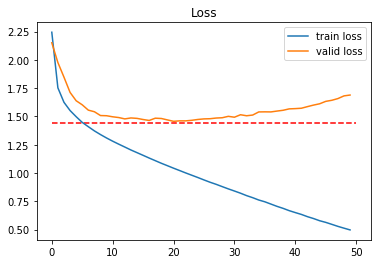

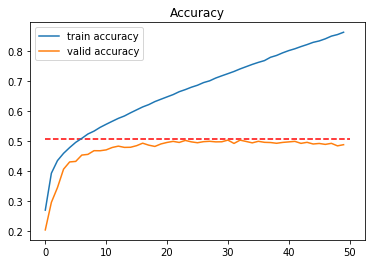

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

In [11]:
# Load back 2: bestfalse, saveweights only fasle
model = keras.models.load_model("./d65HW_FF.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 188us/step


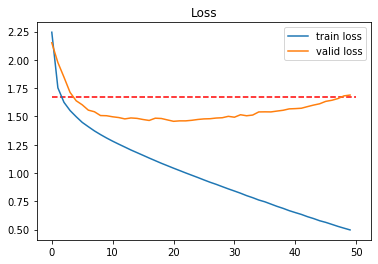

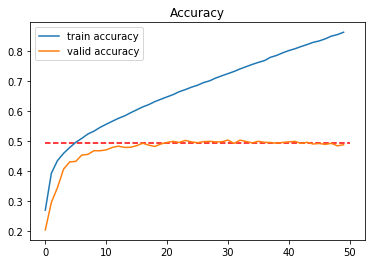

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

In [5]:
# Load back 3: besttrue, saveweights only true
from sklearn.metrics import accuracy_score

model = build_mlp(input_shape=x_train.shape[1:])
model.load_weights("./d65HW_TT.h5")
#loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
new_model_pred = model.predict(x_test)
new_model_loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_loadback_acc)
new_model_pred.head()

NameError: name 'x_train' is not defined

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

In [14]:
# Load back 4: bestfalse, saveweights only true
model = build_mlp(input_shape=x_train.shape[1:])
model.load_weights("./d65HW_TT.h5")
#loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
new_model_pred = model.predict(x_test)
new_model_loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_loadback_acc)

ValueError: Cannot create group in read-only mode.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()